In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from datetime import datetime
import ccxt
import clickhouse_connect
from data_handlers import clickhouse_connection

In [195]:
con = clickhouse_connection()

Connecting to Clickhouse Server
Connected


In [216]:
query = f"""
            SELECT *
            FROM quarters
            WHERE quarter = 1 
        """
resp = con.ch_client.query(query)

In [245]:
df = pd.DataFrame(resp.result_rows, columns= resp.column_names) 
df.set_index('date', inplace=True)
df = df[['TTF', 'DE']]
df.dropna(inplace = True)

## Import Data

In [246]:
log_df = np.log(df)
df['LOG_SUSHI'] = log_df.TTF
df['LOG_UNI'] = log_df.DE

## Backtest

In [247]:
def run_coin_test(df: pd.DataFrame):
    model = VAR(df)
    out = model.select_order(maxlags=10)
    # print('Selected Lag:', out.bic)

    cj_model = coint_johansen(df, det_order=0, k_ar_diff=out.bic)

    y = cj_model.evec

    return np.array([1, (y[1] / y[0])[0]])

def get_bands(df: pd.DataFrame):
    betas = run_coin_test(df)
    vector1 = (df * betas).sum(axis=1)
    vector1 = ((vector1 - vector1.mean())/ vector1.std())

    out = {
        'beta' : betas,
        'ol' : vector1.quantile(0.05),
        'cl' : vector1.quantile(0.4),
        'os' : vector1.quantile(0.95),
        'cs' : vector1.quantile(0.6)
    }
    return out

def run_one_backtest(df, df_1m, start, end):
    train = df[:start]
    test = df_1m[start + pd.Timedelta(days=1):end].copy()

    configs = get_bands(train[['LOG_SUSHI', 'LOG_UNI']])

    test.loc[:, 'vector'] = test.LOG_SUSHI * configs['beta'][0] + test.LOG_UNI * configs['beta'][1]
    df_1m.loc[:, 'vector'] = df_1m.LOG_SUSHI * configs['beta'][0] + df_1m.LOG_UNI * configs['beta'][1]
    test.loc[:, 'beta'] = configs['beta'][1]
    for i in list(configs.keys())[1:]:
        test[i] = configs[i]

    # test.loc[:, 'scaled_vector'] = ((test.vector - test.vector.expanding().mean()) / test.vector.expanding().std())

    test.loc[:, 'scaled_vector'] = (test.vector - df_1m.vector.rolling(7).mean()) / df_1m.vector.rolling(7).std()
    return test

In [248]:
df.index = pd.to_datetime(df.index)

In [249]:
df = df['2020-01-01':]

In [250]:
start = df.index.min() + pd.Timedelta(days=90)
end = df.index.max()

step = pd.Timedelta(days=60)

current = start + step

btest = pd.DataFrame()

while start <= end: 
    print(start, current)

    btest = pd.concat([btest, run_one_backtest(df, df, start, current)], axis=0)

    start = current 
    current += step

2020-03-31 00:00:00 2020-05-30 00:00:00
2020-05-30 00:00:00 2020-07-29 00:00:00
2020-07-29 00:00:00 2020-09-27 00:00:00
2020-09-27 00:00:00 2020-11-26 00:00:00
2020-11-26 00:00:00 2021-01-25 00:00:00
2021-01-25 00:00:00 2021-03-26 00:00:00
2021-03-26 00:00:00 2021-05-25 00:00:00
2021-05-25 00:00:00 2021-07-24 00:00:00
2021-07-24 00:00:00 2021-09-22 00:00:00
2021-09-22 00:00:00 2021-11-21 00:00:00
2021-11-21 00:00:00 2022-01-20 00:00:00
2022-01-20 00:00:00 2022-03-21 00:00:00
2022-03-21 00:00:00 2022-05-20 00:00:00
2022-05-20 00:00:00 2022-07-19 00:00:00
2022-07-19 00:00:00 2022-09-17 00:00:00
2022-09-17 00:00:00 2022-11-16 00:00:00
2022-11-16 00:00:00 2023-01-15 00:00:00
2023-01-15 00:00:00 2023-03-16 00:00:00
2023-03-16 00:00:00 2023-05-15 00:00:00
2023-05-15 00:00:00 2023-07-14 00:00:00


/Users/jan-gobeli/.pyenv/versions/3.11.0/envs/lucy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jan-gobeli/.pyenv/versions/3.11.0/envs/lucy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jan-gobeli/.pyenv/versions/3.11.0/envs/lucy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jan-gobeli/.pyenv/versions/3.11.0/envs/lucy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no

In [251]:
btest.columns = ['price_1', 'price_2', 'log_price_1', 'log_price_2', 'vector', 'beta', 'ol', 'cl', 'os', 'cs', 'scaled_vector']
btest['asset_1'] = 'SUSHI'
btest['asset_2'] = 'UNI'

<AxesSubplot: xlabel='date'>

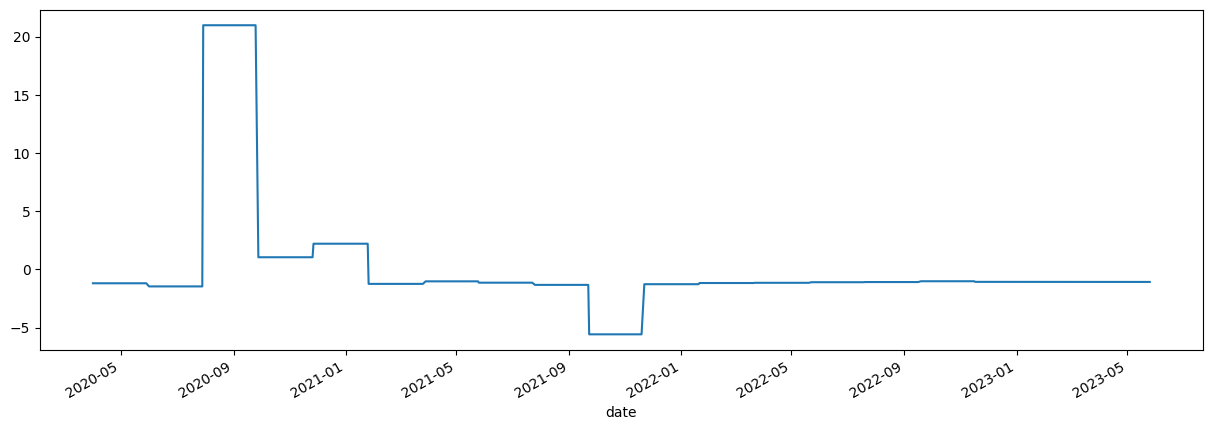

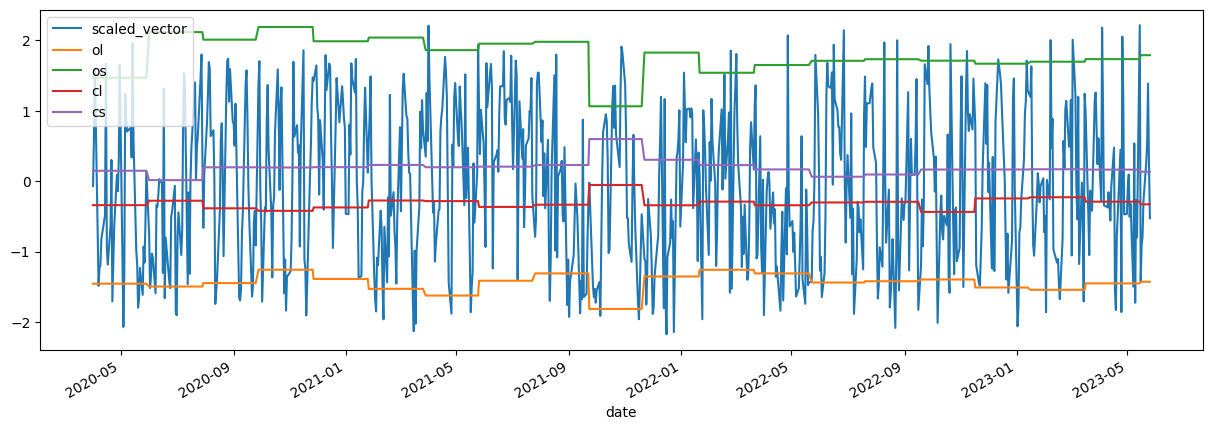

In [252]:
btest.beta.plot(figsize=(15, 5))
btest[['scaled_vector', 'ol', 'os', 'cl', 'cs']].plot(figsize=(15, 5))

In [253]:
class exchange: 
    def __init__(self, balance: int, fee: float = 0.001):
        self.balance = balance 
        self.positions = {}
        self.fee = fee

    def open_position(self, symbol: str, amount: float, price: float):
        self.balance -= amount * price + abs(amount * price * self.fee)
        self.positions[symbol] = amount

    def close_position(self, symbol: str, price: float):
        self.balance += self.positions[symbol] * price - abs(self.positions[symbol] * price * self.fee)
        self.positions.pop(symbol)

<AxesSubplot: xlabel='time'>

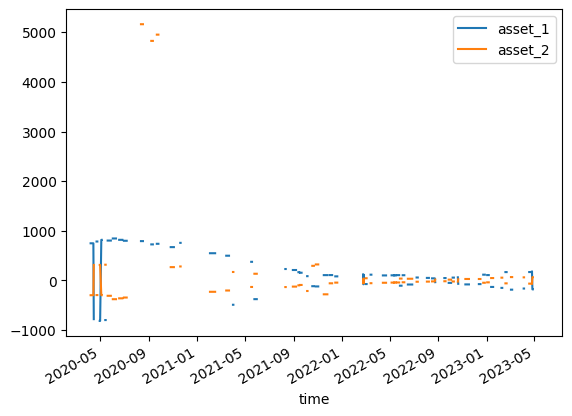

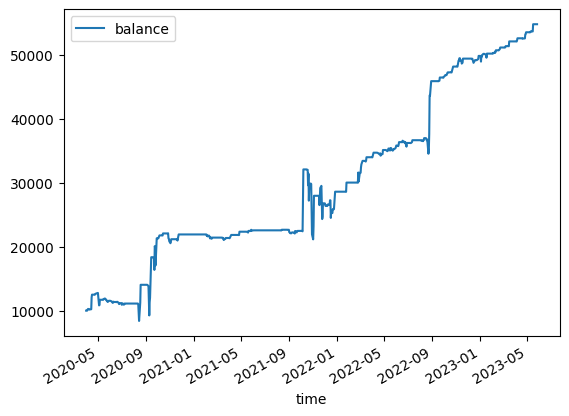

In [254]:
exch = exchange(10_000, fee = 0.001)

base = 10_000

long = False 
short = False

trades = []
balances = []
positions = []

for i, r in btest.iterrows():
    
    if r.scaled_vector > r.os and not short: 
        long = False 
        short = True 

        exch.open_position('asset_1', -1 * base // r.price_1, r.price_1)
        exch.open_position('asset_2', -1 * (base // r.price_2) * r.beta, r.price_2)

        trades.append([i, -1, r.price_1, r.price_2, r.beta])
    
    elif r.scaled_vector < r.ol and not long: 
        short = False 
        long = True 

        exch.open_position('asset_1', 1 * base // r.price_1, r.price_1)
        exch.open_position('asset_2', 1 * (base // r.price_2) * r.beta, r.price_2)

        trades.append([i, 1, r.price_1, r.price_2, r.beta])

    elif r.scaled_vector > r.cl and long: 
        short = False 
        long = False 

        exch.close_position('asset_1', r.price_1)
        exch.close_position('asset_2', r.price_2)

        trades.append([i, 0, r.price_1, r.price_2, r.beta])

    elif r.scaled_vector < r.cs and short: 
        short = False 
        long = False 

        exch.close_position('asset_1', r.price_1)
        exch.close_position('asset_2', r.price_2)

        trades.append([i, 0, r.price_1, r.price_2, r.beta])

    if long or short: 
        balances += [[i, exch.balance + exch.positions['asset_1'] * r.price_1 + exch.positions['asset_2'] * r.price_2]]
    else:
        balances += [[i, exch.balance]]

    positions += [[i] + list(exch.positions.values())]

positions = pd.DataFrame(positions, columns=['time', 'asset_1', 'asset_2'])
positions.set_index('time', inplace=True)
positions.index = pd.to_datetime(positions.index)
positions.plot()

bal = pd.DataFrame(balances, columns=['time', 'balance'])
bal.set_index('time', inplace=True)
bal.index = pd.to_datetime(bal.index)
bal.plot()

In [660]:
t = pd.DataFrame(trades, columns=['ts', 'side', 'SUSHI', 'UNI', 'beta'])

In [661]:
t.set_index('ts', inplace=True)

In [662]:
t['2022-05-10':'2022-06-01']

,side,SUSHI,UNI,beta
ts,,,,
2022-05-11 15:00:00,1,1.443,5.47,-1.289199
2022-05-11 21:00:00,0,1.318,4.90,-1.289199
2022-05-12 07:00:00,-1,1.245,4.32,-1.289199
2022-05-12 15:00:00,0,1.237,4.62,-1.289199
2022-05-12 23:00:00,1,1.144,4.67,-1.289199
2022-05-13 05:00:00,-1,1.626,5.34,-1.289199
2022-05-13 10:00:00,0,1.398,5.24,-1.289199
2022-05-13 19:00:00,1,1.288,5.15,-1.289199
2022-05-13 23:00:00,0,1.402,5.13,-1.289199


## Tests